# Implementing a Plan-and-Execute Agent with Router

In [70]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ['OPEN OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY') # type: ignore

In [71]:
import operator
from typing import TypedDict, Annotated, List, Tuple, Union, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

## 1 - Define the State

Track the plan, past steps, response, and original input

In [72]:
class PlanExecute(TypedDict):
    """State for plan-and-execute agent"""
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## 2 - Create Tools

In [73]:
@tool
def find_contacts() -> list[str]:
    """Gets the contacts from the database"""
    print("TOOL - find_contacts - Contacts got executed")
    return ["Diego Jr.", "Angelica", "Alessa", "Papa", "Mama"]

@tool
def send_email(contact: str, body: str) -> str:
    """Sends an email to a contact"""
    print(f"TOOL - send_email - Email sent to {contact} with body: {body}")
    return f"Email sent to {contact} with body: {body}"

@tool
def create_calendar_event(title: str, date: str, time: str) -> str:
    """Creates a calendar event"""
    print(f"TOOL - create_calendar_event - Created event '{title}' on {date} at {time}")
    return f"Created event '{title}' on {date} at {time}"

tools = [find_contacts, send_email, create_calendar_event]

## 3 - Create the Execution Agent

Use the prebuilt ReAct agent for executing individual tasks

In [74]:
llm = ChatOpenAI(model="gpt-4o")

agent_prompt = """You are a helpful assistant that executes tasks step by step. 
Use the available tools to complete each task accurately."""

agent_executor = create_react_agent(llm, tools, prompt=agent_prompt)

## 4 - Define Plan and Response Models

Use Pydantic models for structured output

In [75]:
class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(
        description="Different steps to follow, should be in sorted order"
    )

class Response(BaseModel):
    """Response to user"""
    response: str

class Act(BaseModel):
    """Action to perform"""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

## 5 - Create Planner and Replanner

In [76]:
# Planner prompt
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan.
This plan should involve individual tasks, that if executed correctly will yield the correct answer.
Do not add any superfluous steps. The result of the final step should be the final answer.
Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("user", "{input}"),
    ]
)

planner = planner_prompt | llm.with_structured_output(Plan)

# Replanner prompt
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan.
This plan should involve individual tasks, that if executed correctly will yield the correct answer.
Do not add any superfluous steps. The result of the final step should be the final answer.
Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that.
Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done.
Do not return previously done steps as part of the plan."""
)

replanner = replanner_prompt | llm.with_structured_output(Act)

## 6 - Define Node Functions

In [77]:
async def plan_step(state: PlanExecute):
    """Generate initial plan"""
    plan = await planner.ainvoke({"input": state["input"]})
    return {"plan": plan.steps}

async def execute_step(state: PlanExecute):
    """Execute the first step of the plan"""
    plan = state["plan"]
    plan_str = "\n".join(f"{i + 1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    
    task_formatted = f"""For the following plan:
{plan_str}

You are tasked with executing step 1: {task}"""
    
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

async def replan_step(state: PlanExecute):
    """Replan based on executed steps"""
    output = await replanner.ainvoke(state)
    
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    """Determine if we should continue or end"""
    if "response" in state and state["response"]:
        return "__end__"
    if not state.get("plan"):
        return "__end__"
    else:
        return "agent"

## 7 - Build the Graph

In [78]:
workflow = StateGraph(PlanExecute)

# Add nodes
workflow.add_node("planner", plan_step)
workflow.add_node("agent", execute_step)
workflow.add_node("replan", replan_step)

# Define edges
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

# Compile the graph
graph = workflow.compile()

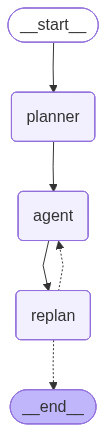

In [79]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## 8 - Test the Agent

In [80]:
# Simple test
config = {"recursion_limit": 50}
inputs = {
    "input": "Send an email to polo@gmail.com saying I can't meet today."
}

async for event in graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(f"{k}: {v}")
            print("-" * 80)

planner: {'plan': ['Open your email client or service (e.g., Gmail, Outlook).', 'Log into your email account using your username and password, if required.', "Click on the 'Compose' button to start a new email.", "In the 'To' field, enter the recipient's email address: polo@gmail.com.", "In the 'Subject' field, type a brief description of the email, such as 'Schedule Change'.", 'In the main body of the email, write your message: "Hi Polo,\\n\\nI hope this message finds you well. Unfortunately, I am unable to meet today. I apologize for any inconvenience this may cause.\\n\\nBest regards,\\n[Your Name]"', 'Review the email for any errors or additional information you might want to include.', "Click on the 'Send' button to send your email."]}
--------------------------------------------------------------------------------
TOOL - send_email - Email sent to polo@gmail.com with body: Hi Polo,

I hope this message finds you well. Unfortunately, I am unable to meet today. I apologize for any 

In [81]:
# Complex multi-step test
complex_inputs = {
    "input": """Envia un correo a polo que su correo es polo@gmail.com de que no podre verlo hoy.
    
    Despues lista mis contactos y enviale a cada contacto el siguiente correo:
    'Hola [nombre] espero que estes bien recuerda que te quiero mucho'
    
    Despues crea un evento en mi calendario para ver a rodrigo el siguiente 10 de Octubre del 2025
    a las 02:00 pm y despues enviale un correo a rodrigo a su correo rodrigo@hotmail.com comentandole
    que si podemos vernos a la fecha y hora en la que hice el evento.
    """
}

async for event in graph.astream(complex_inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(f"\n{k.upper()}:")
            if k == "planner":
                print("Plan created:")
                for i, step in enumerate(v.get("plan", []), 1):
                    print(f"  {i}. {step}")
            elif k == "agent":
                past_steps = v.get("past_steps", [])
                if past_steps:
                    task, result = past_steps[-1]
                    print(f"Executed: {task}")
                    print(f"Result: {result}")
            elif k == "replan":
                if "response" in v:
                    print(f"Final Response: {v['response']}")
                elif "plan" in v:
                    print("Updated plan:")
                    for i, step in enumerate(v["plan"], 1):
                        print(f"  {i}. {step}")
            print("-" * 80)


PLANNER:
Plan created:
  1. Open your email application or service.
  2. Compose a new email to polo@gmail.com with the subject 'No puedo verte hoy'.
  3. Write the message body stating that you won't be able to see him today.
  4. Send the email to polo@gmail.com.
  5. Open your contacts list in your email application or service.
  6. For each contact, repeat the following:
  7. Compose a new email with the subject 'Un saludo'.
  8. Insert '[nombre]' with the actual name of the contact in the message body: 'Hola [nombre] espero que estes bien recuerda que te quiero mucho'.
  9. Send the email to the respective contact's email address.
  10. Open your calendar application or service.
  11. Create a new event with the title 'Ver a Rodrigo'.
  12. Set the date of the event to October 10, 2025.
  13. Set the time of the event to begin at 2:00 PM and end at an appropriate time after this according to your preference.
  14. Save the calendar event.
  15. Compose a new email to rodrigo@hotm